In [5]:
from pyspark.ml.regression import RandomForestRegressionModel
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [6]:
#Load the model from gcs
model_path = "gs://my-big-data-as/models/stock_model"
rf_model = RandomForestRegressionModel.load(model_path)  # Correct class for loading the model

#Load test predictions 
test_predictions_path = "gs://my-big-data-as/models/test_predictions.parquet"
predictions = spark.read.parquet(test_predictions_path)

#Convert the prediction data to Pandas for visualization
predictions_pd = predictions.select("ticker_symbol", "datetime", "next_day_close", "prediction").toPandas()

#Check predictions data
print(predictions_pd.head())

  ticker_symbol   datetime  next_day_close  prediction
0        ADM.US 1998-01-12           22.06   15.548177
1        COO.US 1998-01-20           49.63   48.867450
2        MLM.US 1998-01-20           38.31   32.878294
3        HUM.US 1998-01-23           20.00   15.548177
4        EOG.US 1998-01-26           20.00   15.548177


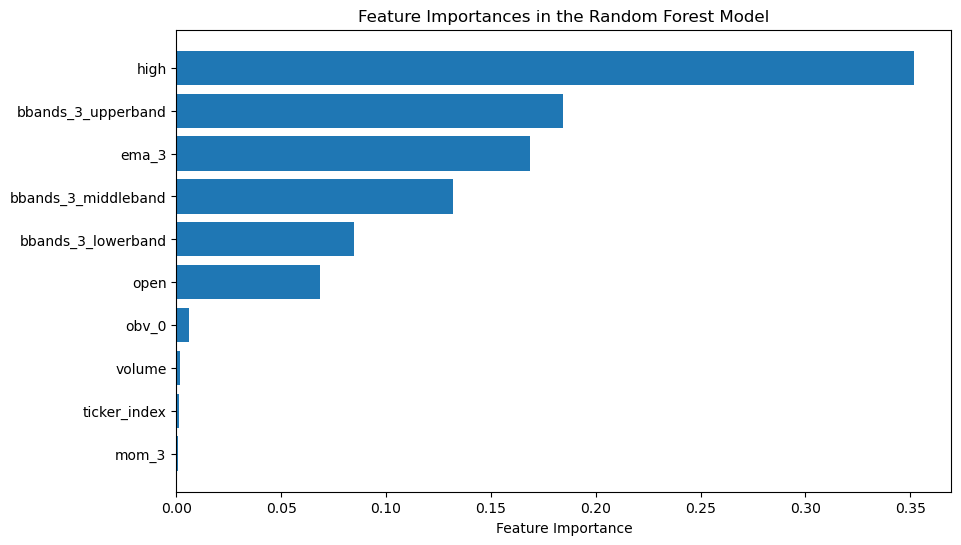

In [8]:
#Call feature importance
feature_importances = rf_model.featureImportances

#Convert feature iumportance to an numpy array
feature_importances_array = feature_importances.toArray()

#Features used in the model
features = ["high", "open", "volume", "obv_0", "mom_3", "ema_3", 
            "bbands_3_upperband", "bbands_3_middleband", "bbands_3_lowerband", "ticker_index"]

#Sort feature importance by most important to least
sorted_idx = np.argsort(feature_importances_array)[::-1]

#Bar graph for feature importances
plt.figure(figsize=(10, 6))
plt.barh(np.array(features)[sorted_idx], feature_importances_array[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importances in the Random Forest Model')
plt.gca().invert_yaxis()  # Invert the axis to have the most important feature on top
plt.show()

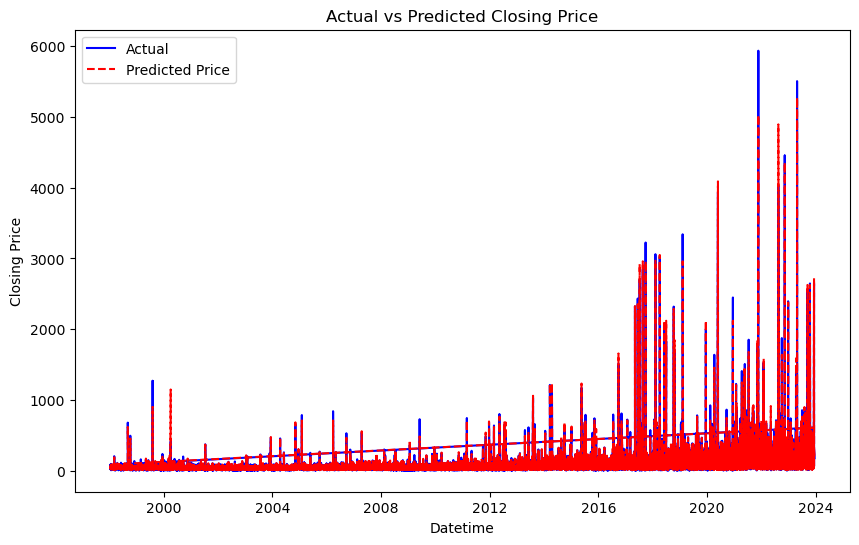

In [9]:
#Charting the actual vs predicted closing price using bar chart by years
plt.figure(figsize=(10, 6))
plt.plot(predictions_pd['datetime'], predictions_pd['next_day_close'], label='Actual', color='blue')
plt.plot(predictions_pd['datetime'], predictions_pd['prediction'], label='Predicted Price', color='red', linestyle='--')
plt.xlabel('Datetime')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Price')
plt.legend()
plt.show()

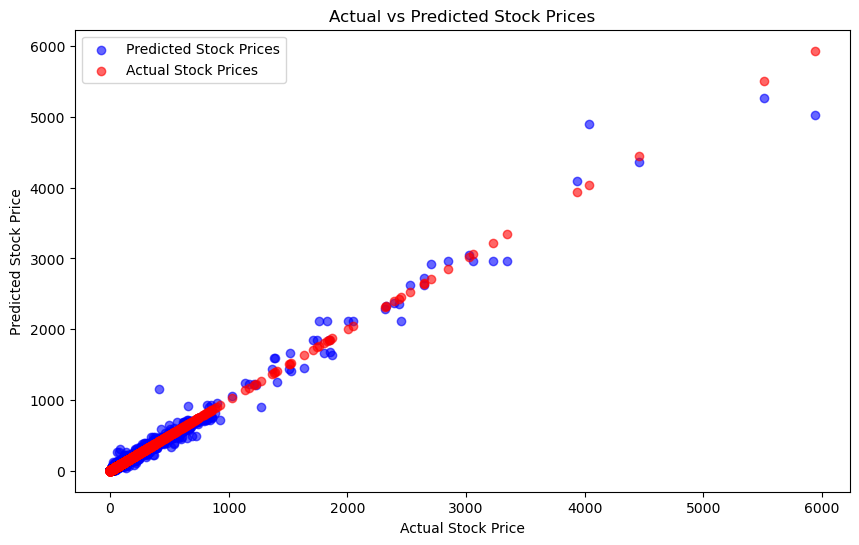

In [11]:
# Extract actual and predicted stock prices
y_true = predictions.select("next_day_close").rdd.flatMap(lambda x: x).collect()  
y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect() 

#Scatter plot of actual vs predicted stock prices
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.6, color='blue', label="Predicted Stock Prices")
plt.scatter(y_true, y_true, alpha=0.6, color='red', label="Actual Stock Prices")
plt.xlabel('Actual Stock Price')
plt.ylabel('Predicted Stock Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

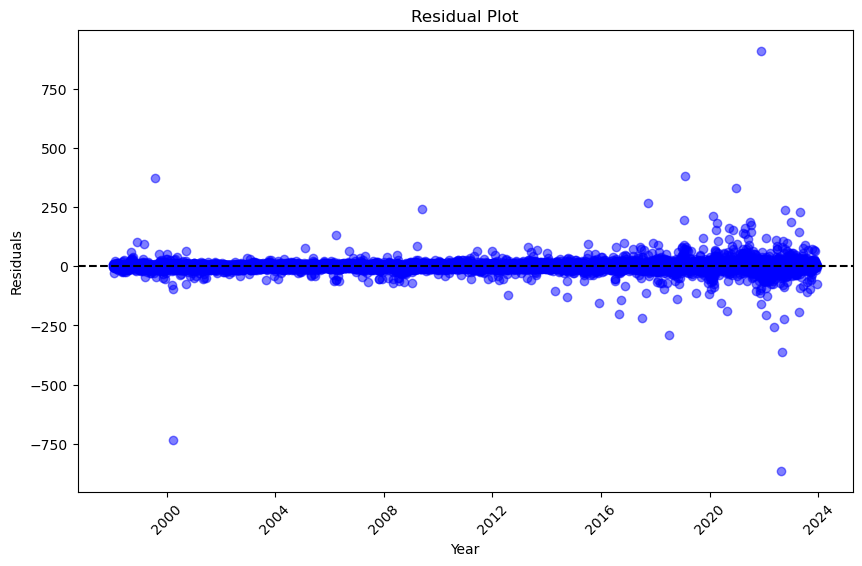

In [20]:
#Calculate Residual
predictions_pd['residual'] = predictions_pd['next_day_close'] - predictions_pd['prediction']

#Plotting residuals 
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd['datetime'], predictions_pd['residual'], alpha=0.5, color='blue')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.xticks(rotation=45)
plt.show()